# Ordinal Cluster Arrangement
C. Heiser, 2019

---
__The purpose of this notebook is to prototype methods for determining ordinal arrangement of substructures within single-cell data.__  
  
To benchmark these techniques, we are using two single-cell RNAseq datasets:
* From [__Macosko, *et al* (2015)__](https://www.ncbi.nlm.nih.gov/pubmed/26000488), the mouse retina scRNA-seq data generated using DropSeq: [GSM1626793](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1626793)
* From [__Herring, *et al* (2018)__](https://www.ncbi.nlm.nih.gov/pubmed/29153838), the WT mouse retina scRNA-seq data generated using inDrops: [GSM2743164](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2743164)  
  
The first set should be __discrete__, containing highly separable cell populations from the mouse retina, where the latter will be __continuous__, representing a continuum of branching cell states in the gut epithelium.  
  
Both datasets have been __preprocessed and feature-selected__ to allow for direct input to downstream dimensionality reduction algorithms (rather than first performing PCA to limit dimensional input). These methods are shown in [`dev/QC.ipynb`](dev/QC.ipynb).

In [1]:
import sys
sys.path.append('../')
from fcc_utils import *
%matplotlib inline

In [2]:
from functools import reduce

In [38]:
# reload functions when editing file
del sys.modules['fcc_utils']
from fcc_utils import *

---
First, read in retina and retina datasets with all genes present

In [3]:
# read in retina data
retina = sc.read_text('../inputs/GSM1626793_P14Retina_1.processed.tsv', delimiter='\t', first_column_names=True)

In [4]:
# look at dimensions of counts matrix (cells, genes)
retina

AnnData object with n_obs × n_vars = 1326 × 500 

In [5]:
# get useful metrics of counts data
retina.var['mito'] = retina.var_names.str.contains('mt-')
sc.pp.calculate_qc_metrics(retina, qc_vars=['mito'], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
retina.layers['raw_counts'] = retina.X.copy() # save raw counts in layer
sc.pp.normalize_total(retina, target_sum=1, layers=None, key_added='norm_factor') # normalize within each cell to get fractional counts
arcsinh(retina, scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']

# see resulting AnnData contents
retina

AnnData object with n_obs × n_vars = 1326 × 500 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

In [6]:
retina.X = retina.layers['arcsinh_norm'].copy()
sc.tl.pca(retina, use_highly_variable=False, n_comps=100)

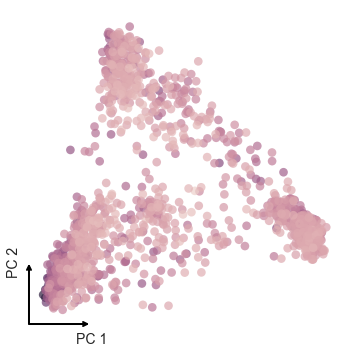

In [7]:
DR_plot(dim_name='PC', figsize=(5,5)).plot(data=retina.obsm['X_pca'], color=retina.obs['log1p_total_counts'])

In [8]:
sc.pp.neighbors(retina, n_neighbors=30, use_rep='X_pca', n_pcs=100, knn=True, random_state=18, metric='euclidean', copy=False)
sc.tl.louvain(retina, key_added='louvain', random_state=18)
retina.obs['cluster_ID'] = 'cluster_' + retina.obs['louvain'].astype(str)

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compile

In [11]:
retina_clu = pd.read_csv('archive/pymethods_out/retina_clu.csv', header=None)

In [22]:
retina.obs['cluster_fcc'] = retina_clu[0].values

... storing 'cluster_ID' as categorical
... storing 'cluster_fcc' as categorical
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):


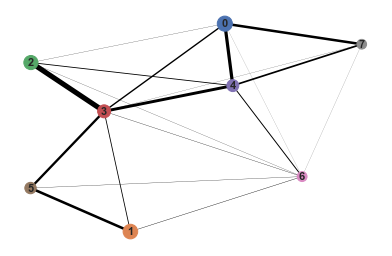

In [14]:
sc.tl.paga(retina)
sc.pl.paga(retina, frameon=False)

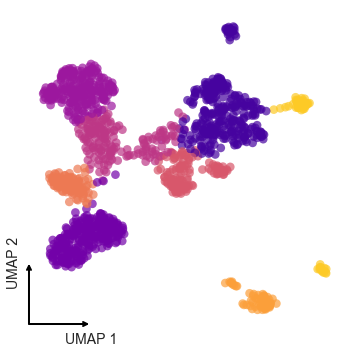

In [16]:
sc.tl.umap(retina, random_state=18, init_pos=sc.tl._utils.get_init_pos_from_paga(retina))
DR_plot(dim_name='UMAP', figsize=(5,5)).plot_IDs(adata=retina, obs_col='cluster_ID', use_rep='X_umap')

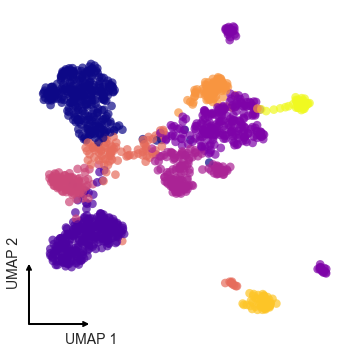

In [24]:
DR_plot(dim_name='UMAP', figsize=(5,5)).plot_IDs(adata=retina, obs_col='cluster_fcc', use_rep='X_umap')

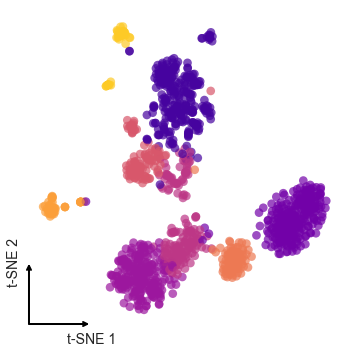

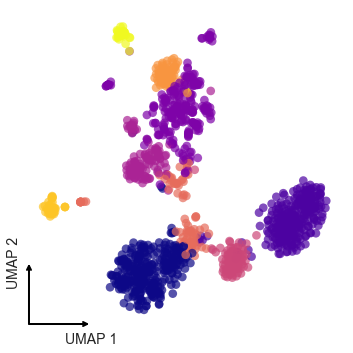

In [26]:
sc.tl.tsne(retina, random_state=18, perplexity=30)
DR_plot(dim_name='t-SNE', figsize=(5,5)).plot_IDs(adata=retina, obs_col='cluster_ID', use_rep='X_tsne')
DR_plot(dim_name='UMAP', figsize=(5,5)).plot_IDs(adata=retina, obs_col='cluster_fcc', use_rep='X_tsne')

In [39]:
find_centroids(retina, use_rep='X_pca', obs_col='cluster_fcc')
find_centroids(retina, use_rep='X_tsne', obs_col='cluster_fcc')
find_centroids(retina, use_rep='X_umap', obs_col='cluster_fcc')

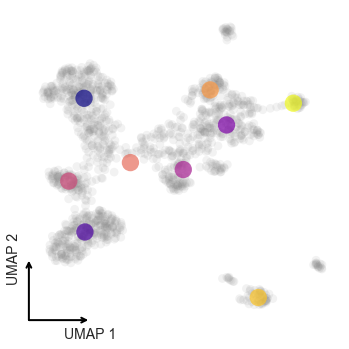

In [40]:
DR_plot(dim_name='UMAP', figsize=(5,5)).plot_centroids(adata=retina, obs_col='cluster_fcc', use_rep='X_umap')

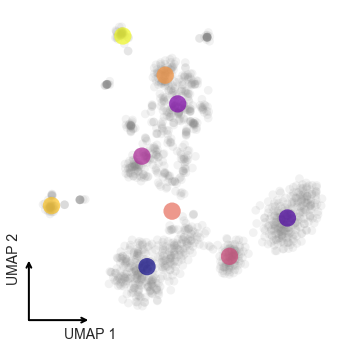

In [41]:
DR_plot(dim_name='UMAP', figsize=(5,5)).plot_centroids(adata=retina, obs_col='cluster_fcc', use_rep='X_tsne')

In [42]:
df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True), [retina.uns['X_pca_centroid_ranks'],retina.uns['X_tsne_centroid_ranks'],retina.uns['X_umap_centroid_ranks']])

In [43]:
df_final.reset_index(inplace=True)

In [44]:
df_final

,index,X_pca,X_tsne,X_umap
0,0.0,0,0,0
1,1.0,7,6,6
2,2.0,3,5,5
3,3.0,2,3,4
4,4.0,5,2,2
5,5.0,1,1,1
6,6.0,4,7,3
7,7.0,8,4,8
8,8.0,6,8,7


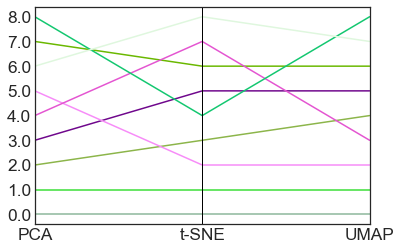

In [45]:
with plt.style.context('seaborn-white'):
    ax = pd.plotting.parallel_coordinates(df_final, class_column='index')
    plt.yticks(ticks=range(len(retina.obs['cluster_fcc'].unique())), labels=df_final['index'], fontsize='x-large')
    plt.xticks(ticks=range(3), labels=['PCA', 't-SNE', 'UMAP'], fontsize='x-large')
    ax.legend().remove()
    ax.grid(False)
    plt.show()